In [4]:
# pull inheritance pattern in region of interest
start, end = 24340000, 24400000

In [5]:
from collections import defaultdict

family_to_individuals = dict()
individual_to_index = dict()
family_to_states = defaultdict(list)
for j in range(3, 7):
    with open('phased/chr.22.familysize.%d.families.txt' % j, 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            for ind_id, index in zip(pieces[1:(1+j)], [int(x) for x in pieces[(1+j):]]):
                individual_to_index[ind_id] = index
                
    # load deletions
    with open('phased/chr.22.familysize.%d.phased.txt' % j, 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+(j*2)):(6+(j*2))]]
            length = end_pos - start_pos + 1
            
            if start_pos >= start and start_pos <= end:
                family_to_states[family_key].append((inheritance_state, start_pos, end_pos))
            elif end_pos >= start and end_pos <= end:
                family_to_states[family_key].append((inheritance_state, start_pos, end_pos))
            elif start_pos <= start and end_pos >= end:
                family_to_states[family_key].append((inheritance_state, start_pos, end_pos))
            elif start_pos >= start and end_pos <= end:
                family_to_states[family_key].append((inheritance_state, start_pos, end_pos))
                
index_to_individual = dict([(v, k) for k, v in individual_to_index.items()])
print('Families', len(family_to_individuals))
print('Missing States', family_to_individuals.keys() - family_to_states.keys())

Families 821
Missing States set()


In [6]:
for family, states in family_to_states.items():
    if len(set([tuple(x[0][4:]) for x in states])) > 1:
        print(family, states)
        
# Remove the one family with a recombination event here
#del family_to_individuals['AU2410.AU2410202.AU2410201']
#del family_to_states['AU2410.AU2410202.AU2410201']

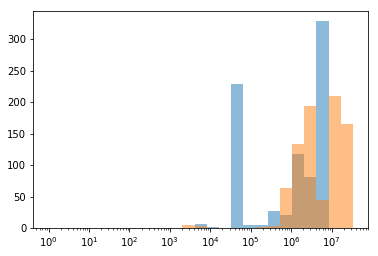

In [10]:
import matplotlib.pyplot as plt
import math

startings, endings = [], []
for family, states in family_to_states.items():
    startings.append(start-min([s[1] for s in states]))
    endings.append(max([s[2] for s in states])-end)
    
max_length = max(startings+endings)
base = 2
plt.hist(startings, alpha=0.5, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
plt.hist(endings, alpha=0.5, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
plt.gca().set_xscale("log")
plt.show()



In [11]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
chrom = 22
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%d' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_gen/chr.%d.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions.append(int(pieces[1]))
snp_positions = np.asarray(snp_positions)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print(m, n)

4610 1096535
4610 1004649


In [12]:
family_to_state = dict([(k, v[0][0][4:]) for k, v in family_to_states.items()])
segment = whole_chrom[:, (snp_positions>=start) & (snp_positions <= end)].A
m, n = segment.shape

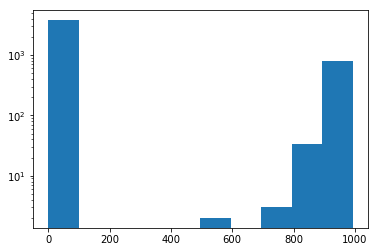

In [13]:
plt.hist(np.sum(segment==-1, axis=1), log=True)
plt.show()

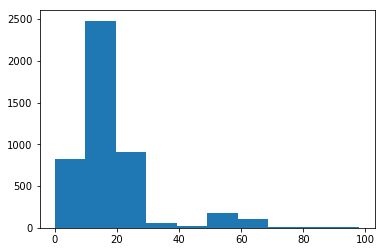

In [14]:
plt.hist(np.sum(segment==1, axis=1))
plt.show()

In [21]:
doubledel_inds = set([index_to_individual[i] for i in np.where(np.sum(segment==-1, axis=1)>200)[0] if i in index_to_individual])
#nodel_inds = set([index_to_individual[i] for i in np.where(np.sum(segment==1, axis=1)>50)[0] if i in index_to_individual])
#nodel_inds = set()
print(len(doubledel_inds))
#print(len(nodel_inds))

699


In [23]:
from itertools import product

anc_variants = np.array(list(product(*[[0, 1]]*4)), dtype=np.int8).T

maternal_transmission_op = set() # child of a single deletion mom (used for TDT)
paternal_transmission_op = set() # child of a single deletion dad (used for TDT)

maternal_deletion = set() # child definitely has a maternal deletion
paternal_deletion = set() # child definitely has a paternal deletion
maybe_maternal_deletion = set() # child might have a maternal deletion
maybe_paternal_deletion = set() # child might have a paternal deletion
no_maternal_deletion = set() # child does not have a maternal deletion
no_paternal_deletion = set() # child does not have a paternal deletion

double_deletion = set() # child or parent definitely has a double deletion
single_deletion = set() # child or parent definitely has a single deletion
no_deletion = set() # child or parent definitely has no deletions
maybe_deletion = set() # child or parent might have a deletion

moms = set()
dads = set()
children = set()

for f, s in family_to_state.items():
    individuals = family_to_individuals[f]
    moms.add(individuals[0])
    dads.add(individuals[1])
    children.update(individuals[2:])
    
    X = np.zeros((len(individuals), 4), dtype=int)
    y = np.ones((len(individuals),), dtype=int)
    X[0, :2] = 1
    X[1, 2:4] = 1
    if individuals[0] in doubledel_inds:
        y[0] = 2
    if individuals[1] in doubledel_inds:
        y[1] = 2
    #if individuals[0] in nodel_inds:
    #    y[0] = 0
    #if individuals[1] in nodel_inds:
    #    y[1] = 0
    for i, child in enumerate(individuals[2:]):
        X[i+2, s[i*2]] = 1
        X[i+2, 2+s[(i*2)+1]] = 1
        if child in doubledel_inds:
            y[i+2] = 2
        #if child in nodel_inds:
        #    y[i+2] = 0
    #print(y)
    good_options = np.where(np.all((X.dot(anc_variants)==2)==(np.outer(y, np.ones((16,)))==2), axis=0))[0]
    if len(good_options) == 0:
        print('No good options', f)
    else:
        options = anc_variants[:, good_options]
        deletions = X.dot(options)
        for i, ind in enumerate(individuals):
            if np.all(np.equal(deletions[i, :], 2)):
                double_deletion.add(ind)
            elif np.all(np.equal(deletions[i, :], 1)):
                single_deletion.add(ind)
                if i == 0:
                    maternal_transmission_op.update(individuals[2:])
                if i == 1:
                    paternal_transmission_op.update(individuals[2:])
            elif np.all(np.equal(deletions[i, :], 0)):
                no_deletion.add(ind)
            else:
                maybe_deletion.add(ind)
                
            if i>=2:
                # child
                if np.all(np.equal(options[s[(i-2)*2], :], 1)):
                    maternal_deletion.add(ind)
                elif np.all(np.equal(options[s[(i-2)*2], :], 0)):
                    no_maternal_deletion.add(ind)
                else:
                    maybe_maternal_deletion.add(ind)
                    
                if np.all(np.equal(options[2+s[((i-2)*2)+1], :], 1)):
                    paternal_deletion.add(ind)
                elif np.all(np.equal(options[2+s[((i-2)*2)+1], :], 0)):
                    no_paternal_deletion.add(ind)
                else:
                    maybe_paternal_deletion.add(ind)
                    
print('Maternal deletions', len(maternal_deletion))
print('Maybe maternal deletions', len(maybe_maternal_deletion))
print('No maternal deletions', len(no_maternal_deletion))

print('Paternal deletions', len(paternal_deletion))
print('Maybe paternal deletions', len(maybe_paternal_deletion))
print('No paternal deletions', len(no_paternal_deletion))       

print('Double deletions', len(double_deletion))
print('Single deletions', len(single_deletion))
print('Maybe deletions', len(maybe_deletion))
print('No deletions', len(no_deletion))

print('Maternal trans op', len(maternal_transmission_op), len(maternal_transmission_op & (maternal_deletion | no_maternal_deletion)))
print('Paternal trans op', len(paternal_transmission_op), len(paternal_transmission_op & (paternal_deletion | no_paternal_deletion)))



No good options AU0487.AU048701.AU048702
No good options AU0923.AU0923202.AU0923201
No good options AU0944.AU0944202.AU0944201
No good options AU1195.AU1195202.AU1195203
No good options AU1390.AU1390202.AU1390201
No good options AU1514.AU1514202.AU1514201
No good options AU1532.AU1532202.AU1532201
No good options AU1626.AU1626202.AU1626201
No good options AU1692.AU1692202.AU1692201
No good options AU1996.AU1996202.AU1996201
No good options AU3302.AU3302202.AU3302201
No good options AU3360.AU3360202.AU3360201
No good options AU0043.AU004301.AU004302
No good options AU0207.AU020701.AU020702
No good options AU0289.AU028901.AU028902
No good options AU0738.AU073801.AU073802
No good options AU0746.AU074601.AU074602
No good options AU0836.AU083601.AU083602
No good options AU0897.AU0897202.AU0897201
No good options AU1072.AU1072202.AU1072201
No good options AU0871.AU0871202.AU0871201
No good options AU1089.AU1089202.AU1089201
No good options AU1340.AU1340202.AU1340201
No good options AU1394.AU

In [18]:
aff_doubledel = len([x for x in children if x in double_deletion and child_id_to_affected[x] == '2'])
aff_singledel = len([x for x in children if x in single_deletion and child_id_to_affected[x] == '2'])
aff_nodel = len([x for x in children if x in no_deletion and child_id_to_affected[x] == '2'])
aff_maybedel = len([x for x in children if x in maybe_deletion and child_id_to_affected[x] == '2'])

unaff_doubledel = len([x for x in children if x in double_deletion and child_id_to_affected[x] != '2'])
unaff_singledel = len([x for x in children if x in single_deletion and child_id_to_affected[x] != '2'])
unaff_nodel = len([x for x in children if x in no_deletion and child_id_to_affected[x] != '2'])
unaff_maybedel = len([x for x in children if x in maybe_deletion and child_id_to_affected[x] != '2'])

mom_doubledel = len([x for x in moms if x in double_deletion])
mom_singledel = len([x for x in moms if x in single_deletion])
mom_nodel = len([x for x in moms if x in no_deletion])
mom_maybedel = len([x for x in moms if x in maybe_deletion])

dad_doubledel = len([x for x in dads if x in double_deletion])
dad_singledel = len([x for x in dads if x in single_deletion])
dad_nodel = len([x for x in dads if x in no_deletion])
dad_maybedel = len([x for x in dads if x in maybe_deletion])

total_aff = len([x for x in children if child_id_to_affected[x] == '2'])
total_unaff = len([x for x in children if child_id_to_affected[x] != '2'])
total_mom = len(moms)
total_dad = len(dads)

total_aff_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_deletion])
total_unaff_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_deletion])
total_mom_known = len([x for x in moms if x not in maybe_deletion])
total_dad_known = len([x for x in dads if x not in maybe_deletion])


print('Confusion')
print('\t\tAffected\tUnaffected\tMom\t\tDad')
print('Double Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_doubledel, aff_doubledel/total_aff_known, 
                                                                      unaff_doubledel, unaff_doubledel/total_unaff_known,
                                                                     mom_doubledel, mom_doubledel/total_mom_known,
                                                                     dad_doubledel, dad_doubledel/total_dad_known))
print('Single Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_singledel, aff_singledel/total_aff_known, 
                                                                      unaff_singledel, unaff_singledel/total_unaff_known,
                                                                     mom_singledel, mom_singledel/total_mom_known,
                                                                     dad_singledel, dad_singledel/total_dad_known))
print('No Del\t\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_nodel, aff_nodel/total_aff_known, 
                                                                    unaff_nodel, unaff_nodel/total_unaff_known,
                                                                   mom_nodel, mom_nodel/total_mom_known,
                                                                   dad_nodel, dad_nodel/total_dad_known))
print('Not Included\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_maybedel, aff_maybedel/total_aff, 
                                                                    unaff_maybedel, unaff_maybedel/total_unaff,
                                                                   mom_maybedel, mom_maybedel/total_mom,
                                                                   dad_maybedel, dad_maybedel/total_dad))

print()
print('Double Del p-value', chi2_contingency([[aff_doubledel, unaff_doubledel], [aff_singledel+aff_nodel, unaff_singledel+unaff_nodel]])[1])
print('No Del p-value', chi2_contingency([[aff_nodel, unaff_nodel], [aff_doubledel+aff_singledel, unaff_doubledel+unaff_singledel]])[1])
print()
print('Del p-value', chi2_contingency([[aff_doubledel, unaff_doubledel], [aff_singledel, unaff_singledel], [aff_nodel, unaff_nodel]])[1])
print('Del allele p-value', chi2_contingency([[2*aff_doubledel+aff_singledel, 2*unaff_doubledel+unaff_singledel], [2*aff_nodel+aff_singledel, 2*unaff_nodel+unaff_singledel]])[1])
print('Mom/Dad p-value', chi2_contingency([[mom_doubledel, dad_doubledel], [mom_singledel, dad_singledel], [mom_nodel, dad_nodel]])[1])


NameError: name 'child_id_to_affected' is not defined

In [19]:
# TDT
aff_male_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and x in maternal_transmission_op])
aff_male_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and x in maternal_transmission_op])
aff_male_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and x in maternal_transmission_op])

aff_female_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1' and x in maternal_transmission_op])
aff_female_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1' and x in maternal_transmission_op])
aff_female_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1' and x in maternal_transmission_op])

unaff_male_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1' and x in maternal_transmission_op])
unaff_male_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1' and x in maternal_transmission_op])
unaff_male_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1' and x in maternal_transmission_op])

unaff_female_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and x in maternal_transmission_op])
unaff_female_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and x in maternal_transmission_op])
unaff_female_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and x in maternal_transmission_op])

aff_male_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and x in paternal_transmission_op])
aff_male_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and x in paternal_transmission_op])
aff_male_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1' and x in paternal_transmission_op])

aff_female_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1' and x in paternal_transmission_op])
aff_female_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1' and x in paternal_transmission_op])
aff_female_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1' and x in paternal_transmission_op])

unaff_male_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1' and x in paternal_transmission_op])
unaff_male_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1' and x in paternal_transmission_op])
unaff_male_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1' and x in paternal_transmission_op])

unaff_female_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and x in paternal_transmission_op])
unaff_female_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and x in paternal_transmission_op])
unaff_female_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1' and x in paternal_transmission_op])

total_aff_male_mat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] == '1' and x in maternal_transmission_op])
total_unaff_male_mat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] == '1' and x in maternal_transmission_op])
total_aff_male_pat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] == '1' and x in paternal_transmission_op])
total_unaff_male_pat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] == '1' and x in paternal_transmission_op])
total_aff_female_mat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] != '1' and x in maternal_transmission_op])
total_unaff_female_mat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] != '1' and x in maternal_transmission_op])
total_aff_female_pat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] != '1' and x in paternal_transmission_op])
total_unaff_female_pat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] != '1' and x in paternal_transmission_op])

total_aff_male = len([x for x in children if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
total_unaff_male = len([x for x in children if child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])
total_aff_female = len([x for x in children if child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])
total_unaff_female = len([x for x in children if child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])

print('Confusion')
print('\t\t\tAffected M\tAffected F\tUnaffected M\tUnaffected F')
print('Maternal Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_maternal, aff_male_maternal/total_aff_male_mat_known, 
                                                     aff_female_maternal, aff_female_maternal/total_aff_female_mat_known,
                                                     unaff_male_maternal, unaff_male_maternal/total_unaff_male_mat_known,
                                                     unaff_female_maternal, unaff_female_maternal/total_unaff_female_mat_known))
print('Maternal No Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_no_maternal, aff_male_no_maternal/total_aff_male_mat_known, 
                                                        aff_female_no_maternal, aff_female_no_maternal/total_aff_female_mat_known,
                                                        unaff_male_no_maternal, unaff_male_no_maternal/total_unaff_male_mat_known,
                                                        unaff_female_no_maternal, unaff_female_no_maternal/total_unaff_female_mat_known))
print('Maternal Not Included\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_maybe_maternal, aff_male_maybe_maternal/total_aff_male, 
                                                         aff_female_maybe_maternal, aff_female_maybe_maternal/total_aff_female, 
                                                         unaff_male_maybe_maternal, unaff_male_maybe_maternal/total_unaff_male, 
                                                         unaff_female_maybe_maternal, unaff_female_maybe_maternal/total_unaff_female))
print()
print('Paternal Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_paternal, aff_male_paternal/total_aff_male_pat_known, 
                                                     aff_female_paternal, aff_female_paternal/total_aff_female_pat_known, 
                                                     unaff_male_paternal, unaff_male_paternal/total_unaff_male_pat_known,
                                                     unaff_female_paternal, unaff_female_paternal/total_unaff_female_pat_known))
print('Paternal No Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_no_paternal, aff_male_no_paternal/total_aff_male_pat_known, 
                                                        aff_female_no_paternal, aff_female_no_paternal/total_aff_female_pat_known, 
                                                        unaff_male_no_paternal, unaff_male_no_paternal/total_unaff_male_pat_known,
                                                        unaff_female_no_paternal, unaff_female_no_paternal/total_unaff_female_pat_known))
print('Paternal Not Included\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_maybe_paternal, aff_male_maybe_paternal/total_aff_male, 
                                                        aff_female_maybe_paternal, aff_female_maybe_paternal/total_aff_female, 
                                                        unaff_male_maybe_paternal, unaff_male_maybe_paternal/total_unaff_male,
                                                        unaff_female_maybe_paternal, unaff_female_maybe_paternal/total_unaff_female))
print()
print('TDT', chi2_contingency([[aff_male_maternal+aff_male_paternal+aff_female_maternal+aff_female_paternal, 
                                unaff_male_maternal+unaff_male_paternal+unaff_female_maternal+unaff_female_paternal], 
                               [aff_male_no_maternal+aff_male_no_paternal+aff_female_no_maternal+aff_female_no_paternal, 
                                unaff_male_no_maternal+unaff_male_no_paternal+unaff_female_no_maternal+unaff_female_no_paternal]])[1])

print('TDT Affected-Mat-Pat-Sex', chi2_contingency(
    [[[[aff_male_maternal, aff_male_paternal], [aff_female_maternal, aff_female_paternal]],
      [[aff_male_no_maternal, aff_male_no_paternal], [aff_female_no_maternal, aff_female_no_paternal]]],
     [[[unaff_male_maternal, unaff_male_paternal], [unaff_female_maternal, unaff_female_paternal]],
      [[unaff_male_no_maternal, unaff_male_no_paternal], [unaff_female_no_maternal, unaff_female_no_paternal]]]])[1])
print('TDT Affected-Mat-Sex', chi2_contingency(
    [[[aff_male_maternal, aff_female_maternal],
      [aff_male_no_maternal, aff_female_no_maternal]],
     [[unaff_male_maternal, unaff_female_maternal],
      [unaff_male_no_maternal, unaff_female_no_maternal]]])[1])
print('TDT Affected-Pat-Sex', chi2_contingency(
    [[[aff_male_paternal, aff_female_paternal],
      [aff_male_no_paternal, aff_female_no_paternal]],
     [[unaff_male_paternal, unaff_female_paternal],
      [unaff_male_no_paternal, unaff_female_no_paternal]]])[1])
print('TDT Affected-Mat-Pat', chi2_contingency(
    [[[aff_male_maternal+aff_female_maternal, aff_male_paternal+aff_female_paternal],
      [aff_male_no_maternal+aff_female_no_maternal, aff_male_no_paternal+aff_female_no_paternal]],
     [[unaff_male_maternal+unaff_female_maternal, unaff_male_paternal+unaff_female_paternal],
      [unaff_male_no_maternal+unaff_female_no_maternal, unaff_male_no_paternal+unaff_female_no_paternal]]])[1])
print('TDT Mat-Pat-Sex', chi2_contingency(
    [[[aff_male_maternal+unaff_male_maternal, aff_male_paternal+unaff_male_paternal], 
       [aff_female_maternal+unaff_female_maternal, aff_female_paternal+unaff_female_paternal]],
      [[aff_male_no_maternal+unaff_male_no_maternal, aff_male_no_paternal+unaff_male_no_paternal], 
       [aff_female_no_maternal+unaff_female_no_maternal, aff_female_no_paternal+unaff_female_no_paternal]]])[1])
print('TDT Affected-Mat', chi2_contingency(
    [[aff_male_maternal+aff_female_maternal,
      aff_male_no_maternal+aff_female_no_maternal],
     [unaff_male_maternal+unaff_female_maternal,
      unaff_male_no_maternal+unaff_female_no_maternal]])[1])
print('TDT Affected-Pat', chi2_contingency(
    [[aff_male_paternal+aff_female_paternal,
      aff_male_no_paternal+aff_female_no_paternal],
     [unaff_male_paternal+unaff_female_paternal,
      unaff_male_no_paternal+unaff_female_no_paternal]])[1])
print('TDT Affected-Sex Mat', chi2_contingency(
    [[aff_male_maternal+aff_male_no_maternal, aff_female_maternal+aff_female_no_maternal],
     [unaff_male_maternal+unaff_male_no_maternal, unaff_female_maternal+unaff_female_no_maternal]])[1])
print('TDT Affected-Sex Pat', chi2_contingency(
    [[aff_male_paternal+aff_male_no_paternal, aff_female_paternal+aff_female_no_paternal],
     [unaff_male_paternal+unaff_male_no_paternal, unaff_female_paternal+unaff_female_no_paternal]])[1])

print()
print('TDT Male', chi2_contingency([[aff_male_maternal+aff_male_paternal, 
                                unaff_male_maternal+unaff_male_paternal], 
                               [aff_male_no_maternal+aff_male_no_paternal,
                                unaff_male_no_maternal+unaff_male_no_paternal]])[1])
print('TDT Female', chi2_contingency([[aff_female_maternal+aff_female_paternal, 
                                unaff_female_maternal+unaff_female_paternal], 
                               [aff_female_no_maternal+aff_female_no_paternal, 
                                unaff_female_no_maternal+unaff_female_no_paternal]])[1])
print('TDT Maternal', chi2_contingency([[aff_male_maternal+aff_female_maternal, 
                                unaff_male_maternal+unaff_female_maternal], 
                               [aff_male_no_maternal+aff_female_no_maternal,
                                unaff_male_no_maternal+unaff_female_no_paternal]])[1])
print('TDT Paternal', chi2_contingency([[aff_male_paternal+aff_female_paternal, 
                                unaff_male_paternal+unaff_female_paternal], 
                               [aff_male_no_paternal+aff_female_no_paternal, 
                                unaff_male_no_paternal+unaff_female_no_paternal]])[1])
print()
print('Maternal Male', chi2_contingency([[aff_male_maternal, unaff_male_maternal], [aff_male_no_maternal, unaff_male_no_maternal]])[1])
print('Paternal Male', chi2_contingency([[aff_male_paternal, unaff_male_paternal], [aff_male_no_paternal, unaff_male_no_paternal]])[1])
print('Maternal Female', chi2_contingency([[aff_female_maternal, unaff_female_maternal], [aff_female_no_maternal, unaff_female_no_maternal]])[1])
print('Paternal Female', chi2_contingency([[aff_female_paternal, unaff_female_paternal], [aff_female_no_paternal, unaff_female_no_paternal]])[1])

print()
print('Same', chi2_contingency([[aff_male_paternal+aff_female_maternal, unaff_male_paternal+unaff_female_maternal], [aff_male_no_paternal+aff_female_no_maternal, unaff_male_no_paternal+unaff_female_no_maternal]])[1])
print('Opposite', chi2_contingency([[aff_male_maternal+aff_female_paternal, unaff_male_maternal+unaff_female_paternal], [aff_male_no_maternal+aff_female_no_paternal, unaff_male_no_maternal+unaff_female_no_paternal]])[1])


NameError: name 'child_id_to_affected' is not defined

In [872]:
print(len(maternal_deletion | no_maternal_deletion))
print(len(paternal_deletion | no_paternal_deletion))
print(len((maternal_deletion | no_maternal_deletion) & (paternal_deletion | no_paternal_deletion)))

835
835
835


[[[156, 46], [80, 19]], [[21, 16], [12, 18]]]
TDT Affected-Mat-Sex 8.84055441662e-07
[[[158, 40], [76, 27]], [[21, 16], [20, 16]]]
TDT Affected-Pat-Sex 0.000185936137478


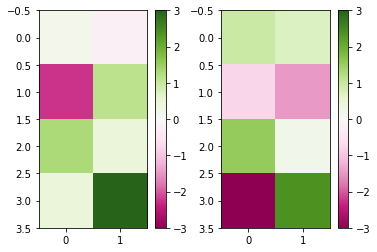

In [873]:
c = [[[aff_male_maternal, aff_female_maternal],
      [aff_male_no_maternal, aff_female_no_maternal]],
     [[unaff_male_maternal, unaff_female_maternal],
      [unaff_male_no_maternal, unaff_female_no_maternal]]]
print(c)
chisq = chi2_contingency(c)
print('TDT Affected-Mat-Sex', chisq[1])
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.reshape(np.power(c-chisq[3], 2)/chisq[3], (4, 2))), vmax=3, vmin=-3, cmap='PiYG')
plt.colorbar()

c = [[[aff_male_paternal, aff_female_paternal],
      [aff_male_no_paternal, aff_female_no_paternal]],
     [[unaff_male_paternal, unaff_female_paternal],
      [unaff_male_no_paternal, unaff_female_no_paternal]]]
print(c)
chisq = chi2_contingency(c)
print('TDT Affected-Pat-Sex', chisq[1])
plt.subplot(1, 2, 2)
plt.imshow(np.log(np.reshape(np.power(c-chisq[3], 2)/chisq[3], (4, 2))), vmax=3, vmin=-3, cmap='PiYG')
plt.colorbar()
plt.show()

In [874]:
aff_male_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
aff_male_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
aff_male_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])

aff_female_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])
aff_female_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])
aff_female_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])

unaff_male_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])
unaff_male_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])
unaff_male_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])

unaff_female_maternal = len([x for x in children if x in maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])
unaff_female_no_maternal = len([x for x in children if x in no_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])
unaff_female_maybe_maternal = len([x for x in children if x in maybe_maternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])

aff_male_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
aff_male_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
aff_male_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])

aff_female_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])
aff_female_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])
aff_female_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])

unaff_male_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])
unaff_male_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])
unaff_male_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])

unaff_female_paternal = len([x for x in children if x in paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])
unaff_female_no_paternal = len([x for x in children if x in no_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])
unaff_female_maybe_paternal = len([x for x in children if x in maybe_paternal_deletion and child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])

total_aff_male_mat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] == '1'])
total_unaff_male_mat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] == '1'])
total_aff_male_pat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] == '1'])
total_unaff_male_pat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] == '1'])
total_aff_female_mat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] != '1'])
total_unaff_female_mat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_maternal_deletion and child_id_to_sex[x] != '1'])
total_aff_female_pat_known = len([x for x in children if child_id_to_affected[x] == '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] != '1'])
total_unaff_female_pat_known = len([x for x in children if child_id_to_affected[x] != '2' and x not in maybe_paternal_deletion and child_id_to_sex[x] != '1'])

total_aff_male = len([x for x in children if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
total_unaff_male = len([x for x in children if child_id_to_affected[x] != '2' and child_id_to_sex[x] == '1'])
total_aff_female = len([x for x in children if child_id_to_affected[x] == '2' and child_id_to_sex[x] != '1'])
total_unaff_female = len([x for x in children if child_id_to_affected[x] != '2' and child_id_to_sex[x] != '1'])

print('Confusion')
print('\t\t\tAffected M\tAffected F\tUnaffected M\tUnaffected F')
print('Maternal Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_maternal, aff_male_maternal/total_aff_male_mat_known, 
                                                     aff_female_maternal, aff_female_maternal/total_aff_female_mat_known,
                                                     unaff_male_maternal, unaff_male_maternal/total_unaff_male_mat_known,
                                                     unaff_female_maternal, unaff_female_maternal/total_unaff_female_mat_known))
print('Maternal No Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_no_maternal, aff_male_no_maternal/total_aff_male_mat_known, 
                                                        aff_female_no_maternal, aff_female_no_maternal/total_aff_female_mat_known,
                                                        unaff_male_no_maternal, unaff_male_no_maternal/total_unaff_male_mat_known,
                                                        unaff_female_no_maternal, unaff_female_no_maternal/total_unaff_female_mat_known))
print('Maternal Not Included\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_maybe_maternal, aff_male_maybe_maternal/total_aff_male, 
                                                         aff_female_maybe_maternal, aff_female_maybe_maternal/total_aff_female, 
                                                         unaff_male_maybe_maternal, unaff_male_maybe_maternal/total_unaff_male, 
                                                         unaff_female_maybe_maternal, unaff_female_maybe_maternal/total_unaff_female))
print()
print('Paternal Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_paternal, aff_male_paternal/total_aff_male_pat_known, 
                                                     aff_female_paternal, aff_female_paternal/total_aff_female_pat_known, 
                                                     unaff_male_paternal, unaff_male_paternal/total_unaff_male_pat_known,
                                                     unaff_female_paternal, unaff_female_paternal/total_unaff_female_pat_known))
print('Paternal No Deletion\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_no_paternal, aff_male_no_paternal/total_aff_male_pat_known, 
                                                        aff_female_no_paternal, aff_female_no_paternal/total_aff_female_pat_known, 
                                                        unaff_male_no_paternal, unaff_male_no_paternal/total_unaff_male_pat_known,
                                                        unaff_female_no_paternal, unaff_female_no_paternal/total_unaff_female_pat_known))
print('Paternal Not Included\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_maybe_paternal, aff_male_maybe_paternal/total_aff_male, 
                                                        aff_female_maybe_paternal, aff_female_maybe_paternal/total_aff_female, 
                                                        unaff_male_maybe_paternal, unaff_male_maybe_paternal/total_unaff_male,
                                                        unaff_female_maybe_paternal, unaff_female_maybe_paternal/total_unaff_female))
print()
print('Maternal Male', chi2_contingency([[aff_male_maternal, unaff_male_maternal], [aff_male_no_maternal, unaff_male_no_maternal]])[1])
print('Paternal Male', chi2_contingency([[aff_male_paternal, unaff_male_paternal], [aff_male_no_paternal, unaff_male_no_paternal]])[1])
print('Maternal Female', chi2_contingency([[aff_female_maternal, unaff_female_maternal], [aff_female_no_maternal, unaff_female_no_maternal]])[1])
print('Paternal Female', chi2_contingency([[aff_female_paternal, unaff_female_paternal], [aff_female_no_paternal, unaff_female_no_paternal]])[1])

print()
print('Same', chi2_contingency([[aff_male_paternal+aff_female_maternal, unaff_male_paternal+unaff_female_maternal], [aff_male_no_paternal+aff_female_no_maternal, unaff_male_no_paternal+unaff_female_no_maternal]])[1])
print('Opposite', chi2_contingency([[aff_male_maternal+aff_female_paternal, unaff_male_maternal+unaff_female_paternal], [aff_male_no_maternal+aff_female_no_paternal, unaff_male_no_maternal+unaff_female_no_paternal]])[1])


Confusion
			Affected M	Affected F	Unaffected M	Unaffected F
Maternal Deletion	372 (0.68)	105 (0.69)	49 (0.67)	43 (0.61)
Maternal No Deletion	171 (0.31)	44 (0.29)	24 (0.33)	27 (0.38)
Maternal Not Included	704 (0.56)	182 (0.54)	80 (0.52)	86 (0.55)

Paternal Deletion	384 (0.70)	102 (0.67)	42 (0.58)	45 (0.63)
Paternal No Deletion	159 (0.29)	47 (0.31)	31 (0.42)	25 (0.35)
Paternal Not Included	704 (0.56)	182 (0.54)	80 (0.52)	86 (0.55)

Maternal Male 0.916491143571
Paternal Male 0.0311662373047
Maternal Female 0.238709900833
Paternal Female 0.646618558519

Same 0.0111838867529
Opposite 0.584778916127


[[[[372, 384], [105, 102]], [[171, 159], [44, 47]]], [[[49, 42], [43, 45]], [[24, 31], [27, 25]]]]
Affected-Mat-Pat-Sex 1.40331893765e-16


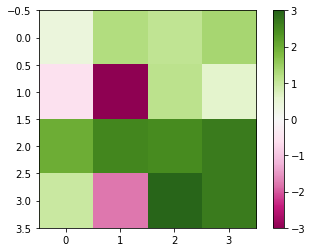

In [876]:
c = [[[[aff_male_maternal, aff_male_paternal], [aff_female_maternal, aff_female_paternal]],
      [[aff_male_no_maternal, aff_male_no_paternal], [aff_female_no_maternal, aff_female_no_paternal]]],
     [[[unaff_male_maternal, unaff_male_paternal], [unaff_female_maternal, unaff_female_paternal]],
      [[unaff_male_no_maternal, unaff_male_no_paternal], [unaff_female_no_maternal, unaff_female_no_paternal]]]]
print(c)
chisq = chi2_contingency(c)
print('Affected-Mat-Pat-Sex', chisq[1])
plt.imshow(np.log(np.reshape(np.power(c-chisq[3], 2)/chisq[3], (4, 4))), vmax=3, vmin=-3, cmap='PiYG')
plt.colorbar()
plt.show()

# Analyze Deletions

In [685]:
from collections import namedtuple

Deletion = namedtuple('Deletion', ['family',
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'is_maternal', 'patterns'])

chrom = '22'
deletions = []
family_to_individuals = dict()
individual_to_indices = dict()

for j in range(3, 6):
    with open('phased/chr.22.familysize.%d.families.txt' % j, 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            for ind_id, index in zip(pieces[1:(1+j)], [int(x) for x in pieces[(1+j):]]):
                individual_to_indices[ind_id] = index
                
    # load deletions
    with open('phased/chr.22.familysize.%d.phased.txt' % j, 'r')  as f:
        next(f) # skip header
        family = None
        maternal_start_pos, maternal_end_pos = -1, -1
        maternal_start_index, maternal_end_index = -1, -1
        maternal_patterns = []
        paternal_start_pos, paternal_end_pos = -1, -1
        paternal_start_index, paternal_end_index = -1, -1
        paternal_patterns = []
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
            start_pos, end_pos, start_index, end_index, score = [int(x) for x in pieces[(2+(j*2)):]]
            length = end_pos - start_pos + 1
            
            if family != family_key:
                family = family_key
                maternal_start_pos, maternal_end_pos = -1, -1
                maternal_start_index, maternal_end_index = -1, -1
                maternal_patterns = []
                paternal_start_pos, paternal_end_pos = -1, -1
                paternal_start_index, paternal_end_index = -1, -1
                paternal_patterns = []
                
            if sum(inheritance_state[:2]) > 0:
                # maternal deletion
                if maternal_start_pos == -1:
                    maternal_start_pos, maternal_start_index = start_pos, start_index
                maternal_end_pos, maternal_end_index = end_pos, end_index
                maternal_patterns.append((inheritance_state, end_pos-start_pos))
            elif maternal_start_pos != -1:
                deletions.append(Deletion(family, maternal_start_pos, maternal_end_pos, maternal_start_index, maternal_end_index, maternal_end_pos-maternal_start_pos, True, maternal_patterns))
                maternal_start_pos, maternal_end_pos = -1, -1
                maternal_start_index, maternal_end_index = -1, -1  
                maternal_patterns = []
                        
            if sum(inheritance_state[2:4]) > 0:
                # paternal deletion
                if paternal_start_pos == -1:
                    paternal_start_pos, paternal_start_index = start_pos, start_index
                paternal_end_pos, paternal_end_index = end_pos, end_index
                paternal_patterns.append((inheritance_state, end_pos-start_pos))
            elif maternal_start_pos != -1:
                deletions.append(Deletion(family, paternal_start_pos, paternal_end_pos, paternal_start_index, paternal_end_index, paternal_end_pos-paternal_start_pos, False, paternal_patterns))
                paternal_start_pos, paternal_end_pos = -1, -1
                paternal_start_index, paternal_end_index = -1, -1 
                paternal_patterns = []

print('length 0 deletions', len([d for d in deletions if d.start_pos == d.end_pos]))
deletions = [d for d in deletions if d.start_pos != d.end_pos]

print('Deletions', len(deletions), 'Maternal', len([x for x in deletions if x.is_maternal]),
     'Paternal', len([x for x in deletions if not x.is_maternal]))
print('Families', len(family_to_individuals))

StopIteration: 

In [765]:
ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

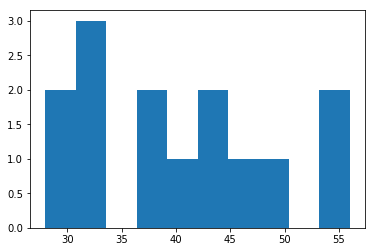

In [687]:
from collections import Counter
import matplotlib.pyplot as plt

# Check for outliers
c = Counter([x.family for x in deletions])
plt.hist(list(c.values()))
plt.show()

min length 0 max length 12805938


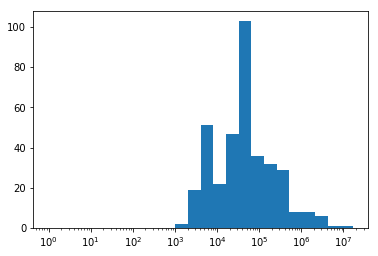

In [688]:
import math

# length of deletions
base = 2
max_length = max([d.length for d in deletions]) 
min_length = min([d.length for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.length for d in deletions], bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
plt.gca().set_xscale("log")
plt.show()

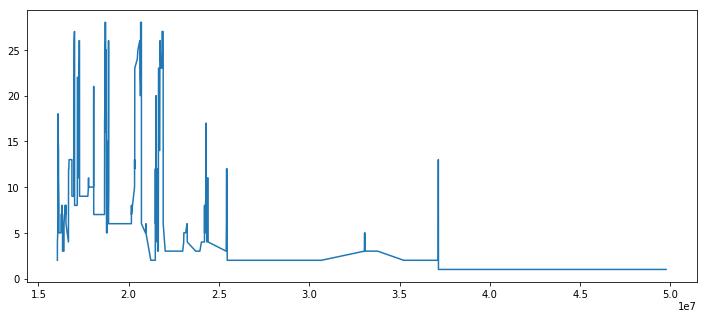

In [689]:
import numpy as np

max_index = max([d.end_index for d in deletions])
snp_positions = np.zeros((max_index+1,))
deldist = np.zeros((max_index+1,))
for d in deletions:
    deldist[d.start_index:(d.end_index+1)] += 1
    snp_positions[d.start_index] = d.start_pos
    snp_positions[d.end_index] = d.end_pos

indices = np.where(snp_positions > 0)[0]

plt.figure(figsize=(12, 5))
plt.plot(snp_positions[indices], deldist[indices])
plt.show()

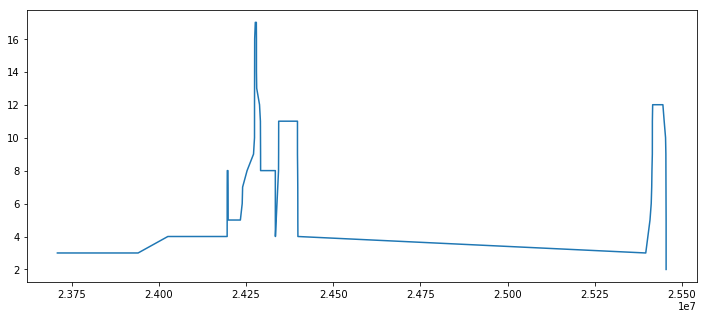

In [690]:
start, end = 23500000, 25900000

indices = np.where((snp_positions > 0) & (snp_positions >= start) & (snp_positions <= end))[0]

plt.figure(figsize=(12, 5))
plt.plot(snp_positions[indices], deldist[indices])
plt.show()

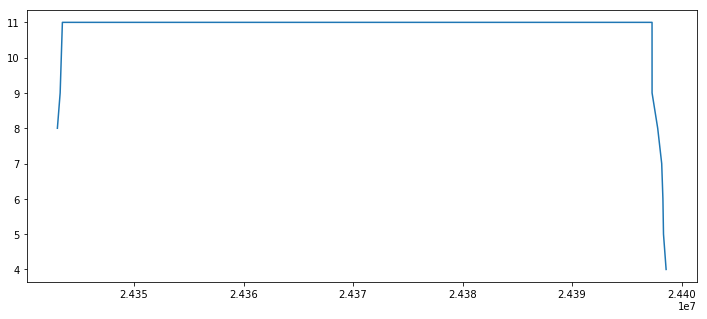

In [691]:
start, end = 24340000, 24400000

indices = np.where((snp_positions > 0) & (snp_positions >= start) & (snp_positions <= end))[0]

plt.figure(figsize=(12, 5))
plt.plot(snp_positions[indices], deldist[indices])
plt.show()

7
5


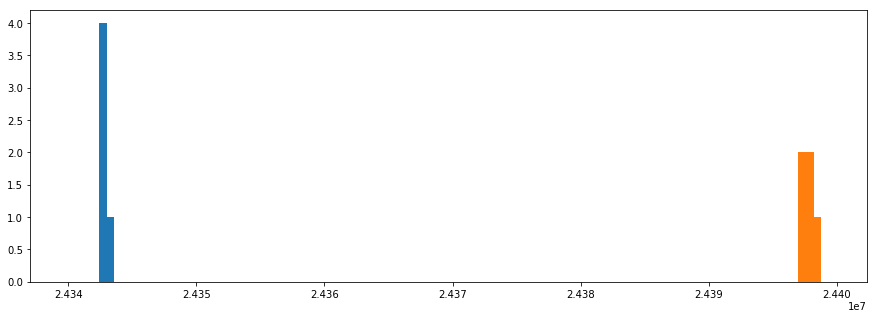

In [692]:
# start and end
delsofinterest = [d for d in deletions if d.start_pos >= start and d.end_pos <= end]
print(len(delsofinterest))
family_to_del = dict()
for d in delsofinterest:
    if d.family not in family_to_del or family_to_del[d.family].length < d.length:
        family_to_del[d.family] = d
delsofinterest = list(family_to_del.values())
print(len(delsofinterest))
        
plt.figure(figsize=(15, 5))
plt.hist([d.start_pos for d in delsofinterest], bins=range(start, end, 600))
plt.hist([d.end_pos for d in delsofinterest], bins=range(start, end, 600))
plt.show()

In [693]:
from scipy.stats import chi2_contingency

aff_male_doubledel, aff_female_doubledel, unaff_male_doubledel, unaff_female_doubledel, mom_doubledel, dad_doubledel = 0, 0, 0, 0, 0, 0
aff_male_singledel_mat, aff_female_singledel_mat, unaff_male_singledel_mat, unaff_female_singledel_mat, mom_singledel, dad_singledel = 0, 0, 0, 0, 0, 0
aff_male_singledel_pat, aff_female_singledel_pat, unaff_male_singledel_pat, unaff_female_singledel_pat, mom_singledel, dad_singledel = 0, 0, 0, 0, 0, 0
aff_male_nodel, aff_female_nodel, unaff_male_nodel, unaff_female_nodel, mom_nodel, dad_nodel = 0, 0, 0, 0, 0, 0

aff_male_mom_doubledel, aff_female_mom_doubledel, unaff_male_mom_doubledel, unaff_female_mom_doubledel = 0, 0, 0, 0
aff_male_mom_singledel, aff_female_mom_singledel, unaff_male_mom_singledel, unaff_female_mom_singledel = 0, 0, 0, 0
aff_male_mom_nodel, aff_female_mom_nodel, unaff_male_mom_nodel, unaff_female_mom_nodel = 0, 0, 0, 0

mom_transop, dad_transop = 0, 0

doubledel_inds = []
singledel_inds = []
nodel_inds = []

for d in delsofinterest:
    individuals = family_to_individuals[d.family]
    inheritance_state = max(d.patterns, key=lambda x: x[1])[0]
    
    if sum(inheritance_state[:2]) == 2:
        mom_doubledel += 1
        doubledel_inds.append(individuals[0])
        for k, child_id in enumerate(individuals[2:]):
            is_affected = child_id_to_affected[child_id] == '2'
            is_male = child_id_to_sex[child_id] == '1'
            
            if is_affected and is_male:
                aff_male_mom_doubledel += 1
            elif is_affected:
                aff_female_mom_doubledel += 1
            elif is_male:
                unaff_male_mom_doubledel += 1
            else:
                unaff_female_mom_doubledel += 1
    elif sum(inheritance_state[:2]) == 1:
        mom_singledel += 1
        singledel_inds.append(individuals[0])
        for k, child_id in enumerate(individuals[2:]):
            is_affected = child_id_to_affected[child_id] == '2'
            is_male = child_id_to_sex[child_id] == '1'
            
            mom_transop += 1
            if is_affected and is_male:
                aff_male_mom_singledel += 1
            elif is_affected:
                aff_female_mom_singledel += 1
            elif is_male:
                unaff_male_mom_singledel += 1
            else:
                unaff_female_mom_singledel += 1
    else:
        mom_nodel += 1
        nodel_inds.append(individuals[0])
        for k, child_id in enumerate(individuals[2:]):
            is_affected = child_id_to_affected[child_id] == '2'
            is_male = child_id_to_sex[child_id] == '1'
            
            if is_affected and is_male:
                aff_male_mom_nodel += 1
            elif is_affected:
                aff_female_mom_nodel += 1
            elif is_male:
                unaff_male_mom_nodel += 1
            else:
                unaff_female_mom_nodel += 1
        
        
    if sum(inheritance_state[2:4]) == 2:
        doubledel_inds.append(individuals[1])
        dad_doubledel += 1
    elif sum(inheritance_state[2:4]) == 1:
        dad_singledel += 1
        singledel_inds.append(individuals[1])
        for k, child_id in enumerate(individuals[2:]):
            is_affected = child_id_to_affected[child_id] == '2'
            is_male = child_id_to_sex[child_id] == '1'
            
            dad_transop += 1
    else:
        nodel_inds.append(individuals[1])
        dad_nodel += 1
                
    for k, child_id in enumerate(individuals[2:]):
        is_affected = child_id_to_affected[child_id] == '2'
        is_male = child_id_to_sex[child_id] == '1'
        is_mat_inherited = inheritance_state[inheritance_state[4+(2*k)]] == 1
        is_pat_inherited = inheritance_state[2+inheritance_state[5+(2*k)]] == 1

        if is_affected and is_male:
            if is_mat_inherited and is_pat_inherited:
                doubledel_inds.append(child_id)
                aff_male_doubledel += 1
            elif is_mat_inherited:
                singledel_inds.append(child_id)
                aff_male_singledel_mat += 1
            elif is_pat_inherited:
                singledel_inds.append(child_id)
                aff_male_singledel_pat += 1
            else:
                nodel_inds.append(child_id)
                aff_male_nodel += 1
        elif is_affected:
            if is_mat_inherited and is_pat_inherited:
                doubledel_inds.append(child_id)
                aff_female_doubledel += 1
            elif is_mat_inherited:
                singledel_inds.append(child_id)
                aff_female_singledel_mat += 1
            elif is_pat_inherited:
                singledel_inds.append(child_id)
                aff_female_singledel_pat += 1
            else:
                nodel_inds.append(child_id)
                aff_female_nodel += 1
        elif is_male:
            if is_mat_inherited and is_pat_inherited:
                doubledel_inds.append(child_id)
                unaff_male_doubledel += 1
            elif is_mat_inherited:
                singledel_inds.append(child_id)
                unaff_male_singledel_mat += 1
            elif is_pat_inherited:
                singledel_inds.append(child_id)
                unaff_male_singledel_pat += 1
            else:
                nodel_inds.append(child_id)
                unaff_male_nodel += 1
        else:
            if is_mat_inherited and is_pat_inherited:
                doubledel_inds.append(child_id)
                unaff_female_doubledel += 1
            elif is_mat_inherited:
                singledel_inds.append(child_id)
                unaff_female_singledel_mat += 1
            elif is_pat_inherited:
                singledel_inds.append(child_id)
                unaff_female_singledel_pat += 1
            else:
                nodel_inds.append(child_id)
                unaff_female_nodel += 1
    
total_aff_male = aff_male_doubledel + aff_male_singledel_mat + aff_male_singledel_pat + aff_male_nodel
total_unaff_male = unaff_male_doubledel + unaff_male_singledel_mat + unaff_male_singledel_pat + unaff_male_nodel
total_aff_female = aff_female_doubledel + aff_female_singledel_mat + aff_female_singledel_pat + aff_female_nodel
total_unaff_female = unaff_female_doubledel + unaff_female_singledel_mat + unaff_female_singledel_pat + unaff_female_nodel

aff_doubledel = aff_male_doubledel + aff_female_doubledel
unaff_doubledel = unaff_male_doubledel + unaff_female_doubledel
aff_singledel_mat = aff_male_singledel_mat + aff_female_singledel_mat
aff_singledel_pat = aff_male_singledel_pat + aff_female_singledel_pat
unaff_singledel_mat = unaff_male_singledel_mat + unaff_female_singledel_mat
unaff_singledel_pat = unaff_male_singledel_pat + unaff_female_singledel_pat

aff_nodel = aff_male_nodel + aff_female_nodel
unaff_nodel = unaff_male_nodel + unaff_female_nodel

total_aff = aff_doubledel + aff_singledel_mat + aff_singledel_pat + aff_nodel
total_unaff = unaff_doubledel + unaff_singledel_mat + unaff_singledel_pat + unaff_nodel
total_mom = mom_doubledel + mom_singledel + mom_nodel
total_dad = dad_doubledel + dad_singledel + dad_nodel

all_families_total_aff = sum([len([x for x in ind[2:] if child_id_to_affected[x] == '2']) for f, ind in family_to_individuals.items()])
all_families_total_unaff = sum([len([x for x in ind[2:] if child_id_to_affected[x] != '2']) for f, ind in family_to_individuals.items()])

print('Confusion')
print('\t\tAffected\tUnaffected\tMom\t\tDad')
print('Double Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_doubledel, aff_doubledel/total_aff, 
                                                                      unaff_doubledel, unaff_doubledel/total_unaff,
                                                                     mom_doubledel, mom_doubledel/total_mom,
                                                                     dad_doubledel, dad_doubledel/total_dad))
print('Single Del Mat\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_singledel_mat, aff_singledel_mat/total_aff, 
                                                                      unaff_singledel_mat, unaff_singledel_mat/total_unaff,
                                                                     mom_singledel, mom_singledel/total_mom,
                                                                     dad_singledel, dad_singledel/total_dad))
print('Single Del Pat\t%d (%0.2f)\t%d (%0.2f)' % (aff_singledel_pat, aff_singledel_pat/total_aff, 
                                                                      unaff_singledel_pat, unaff_singledel_pat/total_unaff))
print('No Del\t\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_nodel, aff_nodel/total_aff, 
                                                                    unaff_nodel, unaff_nodel/total_unaff,
                                                                   mom_nodel, mom_nodel/total_mom,
                                                                   dad_nodel, dad_nodel/total_dad))
print('Not Included\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (all_families_total_aff-total_aff, (all_families_total_aff-total_aff)/all_families_total_aff, 
                                                                    all_families_total_unaff-total_unaff, (all_families_total_unaff-total_unaff)/all_families_total_unaff, 
                                                                   len(family_to_individuals)-total_mom, (len(family_to_individuals)-total_mom)/len(family_to_individuals),
                                                                   len(family_to_individuals)-total_dad, (len(family_to_individuals)-total_dad)/len(family_to_individuals)))
print('Double Del p-value', chi2_contingency([[aff_doubledel, unaff_doubledel], [aff_singledel+aff_nodel, unaff_singledel+unaff_nodel]])[1])
print('No Del p-value', chi2_contingency([[aff_nodel, unaff_nodel], [aff_doubledel+aff_singledel, unaff_doubledel+unaff_singledel]])[1])
print('Del p-value', chi2_contingency([[aff_doubledel, unaff_doubledel], [aff_singledel, unaff_singledel], [aff_nodel, unaff_nodel]])[1])
print('Del allele p-value', chi2_contingency([[2*aff_doubledel+aff_singledel, 2*unaff_doubledel+unaff_singledel], [2*aff_nodel+aff_singledel, 2*unaff_nodel+unaff_singledel]])[1])
#print('Mom/Dad p-value', chi2_contingency([[mom_doubledel, dad_doubledel], [mom_singledel, dad_singledel], [mom_nodel, dad_nodel]])[1])
print('Mom/Dad p-value', chi2_contingency([[mom_singledel, dad_singledel], [mom_nodel, dad_nodel]])[1])

print('Mat/Pat p-value', chi2_contingency([[aff_singledel_mat, aff_singledel_pat], [unaff_singledel_mat, unaff_singledel_pat]])[1])

print('Del p-value Mat', chi2_contingency([[aff_doubledel+aff_singledel_mat, unaff_doubledel+unaff_singledel_mat], [aff_singledel_pat+aff_nodel, unaff_singledel_pat+unaff_nodel]])[1])
print('Del p-value Mat Female', chi2_contingency([[aff_female_doubledel+aff_female_singledel_mat, unaff_female_doubledel+unaff_female_singledel_mat], [aff_female_singledel_pat+aff_female_nodel, unaff_female_singledel_pat+unaff_female_nodel]])[1])
print('Del p-value Mat Male', chi2_contingency([[aff_male_doubledel+aff_male_singledel_mat, unaff_male_doubledel+unaff_male_singledel_mat], [aff_male_singledel_pat+aff_male_nodel, unaff_male_singledel_pat+unaff_male_nodel]])[1])
print('Del p-value Mat Female Allele', chi2_contingency([[2*aff_female_doubledel+aff_female_singledel_mat, 2*unaff_female_doubledel+unaff_female_singledel_mat], [aff_female_singledel_pat+2*aff_female_nodel, unaff_female_singledel_pat+2*unaff_female_nodel]])[1])

print('Del p-value Pat', chi2_contingency([[aff_doubledel+aff_singledel_pat, unaff_doubledel+unaff_singledel_pat], [aff_singledel_mat+aff_nodel, unaff_singledel_mat+unaff_nodel]])[1])
print('Del p-value Pat Female', chi2_contingency([[aff_female_doubledel+aff_female_singledel_pat, unaff_female_doubledel+unaff_female_singledel_pat], [aff_female_singledel_mat+aff_female_nodel, unaff_female_singledel_mat+unaff_female_nodel]])[1])
print('Del p-value Pat Male', chi2_contingency([[aff_male_doubledel+aff_male_singledel_pat, unaff_male_doubledel+unaff_male_singledel_pat], [aff_male_singledel_mat+aff_male_nodel, unaff_male_singledel_mat+unaff_male_nodel]])[1])
print('Del p-value Pat Male Allele', chi2_contingency([[2*aff_male_doubledel+aff_male_singledel_pat, 2*unaff_male_doubledel+unaff_male_singledel_pat], [aff_male_singledel_mat+2*aff_male_nodel, unaff_male_singledel_mat+2*unaff_male_nodel]])[1])

print('Del p-value Sex, Mat/Pat Match', chi2_contingency([[aff_male_doubledel+aff_male_singledel_pat+aff_female_doubledel+aff_female_singledel_mat, 
                                                           unaff_male_doubledel+unaff_male_singledel_pat+unaff_female_doubledel+unaff_female_singledel_mat], 
                                                          [aff_male_singledel_mat+aff_male_nodel+aff_female_singledel_pat+aff_female_nodel, 
                                                           unaff_male_singledel_mat+unaff_male_nodel+unaff_female_singledel_pat+unaff_female_nodel]])[1])
print('Del p-value Sex, Mat/Pat Match Allele', chi2_contingency([[2*aff_male_doubledel+aff_male_singledel_pat+2*aff_female_doubledel+aff_female_singledel_mat, 
                                                           2*unaff_male_doubledel+unaff_male_singledel_pat+2*unaff_female_doubledel+unaff_female_singledel_mat], 
                                                          [aff_male_singledel_mat+2*aff_male_nodel+aff_female_singledel_pat+2*aff_female_nodel, 
                                                           unaff_male_singledel_mat+2*unaff_male_nodel+unaff_female_singledel_pat+2*unaff_female_nodel]])[1])


Confusion
		Affected	Unaffected	Mom		Dad
Double Del	4 (0.80)	0 (0.00)	2 (0.40)	1 (0.20)
Single Del Mat	1 (0.20)	0 (0.00)	2 (0.40)	4 (0.80)
Single Del Pat	0 (0.00)	1 (1.00)
No Del		0 (0.00)	0 (0.00)	1 (0.20)	0 (0.00)
Not Included	12 (0.71)	1 (0.50)	9 (0.64)	9 (0.64)
Double Del p-value 0.802033974283


ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

In [ ]:
print('Mom transmission rate', (aff_singledel_mat+unaff_singledel_mat)/mom_transop)
print('Dad transmission rate', (aff_singledel_pat+unaff_singledel_pat)/dad_transop)
print(Counter([tuple(max(d.patterns, key=lambda x: x[1])[0][:4]) for d in delsofinterest]))


In [ ]:
print('Confusion')
print('\t\tAffected M\tAffected F\tUnaffected M\tUnaffected F')
print('Mom Double Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_mom_doubledel, aff_male_mom_doubledel/total_aff_male, 
                                                                      aff_female_mom_doubledel, aff_female_mom_doubledel/total_aff_female,
                                                                     unaff_male_mom_doubledel, unaff_male_mom_doubledel/total_unaff_male,
                                                                     unaff_female_mom_doubledel, unaff_female_mom_doubledel/total_unaff_female))
print('Mom Single Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_mom_singledel, aff_male_mom_singledel/total_aff_male, 
                                                                      aff_female_mom_singledel, aff_female_mom_singledel/total_aff_female,
                                                                     unaff_male_mom_singledel, unaff_male_mom_singledel/total_unaff_male,
                                                                     unaff_female_mom_singledel, unaff_female_mom_singledel/total_unaff_female))
print('Mom No Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (aff_male_mom_nodel, aff_male_mom_nodel/total_aff_male, 
                                                                      aff_female_mom_nodel, aff_female_mom_nodel/total_aff_female,
                                                                     unaff_male_mom_nodel, unaff_male_mom_nodel/total_unaff_male,
                                                                     unaff_female_mom_nodel, unaff_female_mom_nodel/total_unaff_female))

print('Mom del, affected pvalue', chi2_contingency([
        #[aff_male_mom_doubledel+aff_female_mom_doubledel, 
         #unaff_male_mom_doubledel+unaff_female_mom_doubledel], 
        [aff_male_mom_singledel+aff_female_mom_singledel, 
         unaff_male_mom_singledel+unaff_female_mom_singledel], 
        [aff_male_mom_nodel+aff_female_mom_nodel, 
         unaff_male_mom_nodel+unaff_female_mom_nodel]])[1])
print('Mom del, affected, Female pvalue', chi2_contingency([
        #[aff_female_mom_doubledel, 
        # unaff_female_mom_doubledel], 
        [aff_female_mom_singledel, 
         unaff_female_mom_singledel], 
        [aff_female_mom_nodel, 
         unaff_female_mom_nodel]])[1])
print('Mom del, affected, Male pvalue', chi2_contingency([
        #[aff_male_mom_doubledel, 
        # unaff_male_mom_doubledel], 
        [aff_male_mom_singledel, 
         unaff_male_mom_singledel], 
        [aff_male_mom_nodel, 
         unaff_male_mom_nodel]])[1])
print('Mom del, sex pvalue', chi2_contingency([
        #[aff_male_mom_doubledel+unaff_male_mom_doubledel, 
        # aff_female_mom_doubledel+unaff_female_mom_doubledel], 
        [aff_male_mom_singledel+unaff_male_mom_singledel, 
         aff_female_mom_singledel+unaff_female_mom_singledel], 
        [aff_male_mom_nodel+unaff_male_mom_nodel, 
         aff_female_mom_nodel+unaff_female_mom_nodel]])[1])

In [694]:
print('Confusion')
print('\t\tAffected M\t Affected f\tUnaffected M\tUnaffected F\tMom\t\tDad')
print('Double Del\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (
    aff_male_doubledel, aff_male_doubledel/total_aff_male,
    aff_female_doubledel, aff_female_doubledel/total_aff_female,
    unaff_male_doubledel, unaff_male_doubledel/total_unaff_male,
    unaff_female_doubledel, unaff_female_doubledel/total_unaff_female,
    mom_doubledel, mom_doubledel/total_mom,
    dad_doubledel, dad_doubledel/total_dad))
print('Single Del Mat\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (
    aff_male_singledel_mat, aff_male_singledel_mat/total_aff_male, 
    aff_female_singledel_mat, aff_female_singledel_mat/total_aff_female, 
    unaff_male_singledel_mat, unaff_male_singledel_mat/total_unaff_male,
    unaff_female_singledel_mat, unaff_female_singledel_mat/total_unaff_female,
    mom_singledel, mom_singledel/total_mom,
    dad_singledel, dad_singledel/total_dad))
print('Single Del Pat\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (
    aff_male_singledel_pat, aff_male_singledel_pat/total_aff_male, 
    aff_female_singledel_pat, aff_female_singledel_pat/total_aff_female, 
    unaff_male_singledel_pat, unaff_male_singledel_pat/total_unaff_male,
    unaff_female_singledel_pat, unaff_female_singledel_pat/total_unaff_female,
    mom_singledel, mom_singledel/total_mom,
    dad_singledel, dad_singledel/total_dad))
print('No Del\t\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)\t%d (%0.2f)' % (
    aff_male_nodel, aff_male_nodel/total_aff_male, 
    aff_female_nodel, aff_female_nodel/total_aff_female, 
    unaff_male_nodel, unaff_male_nodel/total_unaff_male,
    unaff_female_nodel, unaff_female_nodel/total_unaff_female,
    mom_nodel, mom_nodel/total_mom,
    dad_nodel, dad_nodel/total_dad))

#print([[[aff_male_singledel_mat, aff_male_singledel_pat], [unaff_male_singledel_mat, unaff_male_singledel_pat]], [[aff_female_singledel_mat, aff_female_singledel_pat], [unaff_female_singledel_mat, unaff_female_singledel_pat]]])
#print('Affected, Gender, Mat/Pat p-value', chi2_contingency([[[aff_male_singledel_mat, aff_male_singledel_pat], [unaff_male_singledel_mat, unaff_male_singledel_pat]], [[aff_female_singledel_mat, aff_female_singledel_pat], [unaff_female_singledel_mat, unaff_female_singledel_pat]]]))
print([[[aff_male_singledel_mat+aff_male_doubledel, aff_male_singledel_pat+aff_male_doubledel], [unaff_male_singledel_mat+unaff_male_doubledel, unaff_male_singledel_pat+unaff_male_doubledel]], [[aff_female_singledel_mat+aff_female_doubledel, aff_female_singledel_pat+aff_female_doubledel], [unaff_female_singledel_mat+unaff_female_doubledel, unaff_female_singledel_pat+unaff_female_doubledel]]])
print('Affected, Sex, Mat/Pat p-value', chi2_contingency([[[aff_male_singledel_mat+aff_male_doubledel, aff_male_singledel_pat+aff_male_doubledel], [unaff_male_singledel_mat+unaff_male_doubledel, unaff_male_singledel_pat+unaff_male_doubledel]], [[aff_female_singledel_mat+aff_female_doubledel, aff_female_singledel_pat+aff_female_doubledel], [unaff_female_singledel_mat+unaff_female_doubledel, unaff_female_singledel_pat+unaff_female_doubledel]]]))

print([[total_aff_male, total_aff_female], [total_unaff_male, total_unaff_female]])
print('Affected, Sex', chi2_contingency([
    [total_aff_male, total_aff_female], 
    [total_unaff_male, total_unaff_female]])[1])

print('Affected, Sex Mat', chi2_contingency([
    [aff_male_singledel_mat+aff_male_doubledel, 
     aff_female_singledel_mat+aff_female_doubledel], 
    [unaff_male_singledel_mat+unaff_male_doubledel, 
     unaff_female_singledel_mat+unaff_female_doubledel]])[1])

print('Affected, Sex Pat', chi2_contingency([
    [aff_male_singledel_pat+aff_male_doubledel, 
     aff_female_singledel_pat+aff_female_doubledel], 
    [unaff_male_singledel_pat+unaff_male_doubledel, 
     unaff_female_singledel_pat+unaff_female_doubledel]])[1])

print([[aff_male_singledel_mat+aff_male_doubledel+aff_female_singledel_mat+aff_female_doubledel, 
         aff_male_singledel_pat+aff_male_doubledel+aff_female_singledel_pat+aff_female_doubledel], 
        [unaff_male_singledel_mat+unaff_male_doubledel+unaff_female_singledel_mat+unaff_female_doubledel, 
         unaff_male_singledel_pat+unaff_male_doubledel+unaff_female_singledel_pat+unaff_female_doubledel]])
print('Affected, Mat/Pat', chi2_contingency([[aff_male_singledel_mat+aff_male_doubledel+aff_female_singledel_mat+aff_female_doubledel, 
         aff_male_singledel_pat+aff_male_doubledel+aff_female_singledel_pat+aff_female_doubledel], 
        [unaff_male_singledel_mat+unaff_male_doubledel+unaff_female_singledel_mat+unaff_female_doubledel, 
         unaff_male_singledel_pat+unaff_male_doubledel+unaff_female_singledel_pat+unaff_female_doubledel]])[1])

print('Affected, Mat/Pat Female', chi2_contingency([
        [aff_female_singledel_mat+aff_female_doubledel, 
         aff_female_singledel_pat+aff_female_doubledel], 
        [unaff_female_singledel_mat+unaff_female_doubledel, 
         unaff_female_singledel_pat+unaff_female_doubledel]])[1])

print('Affected, Mat/Pat Male', chi2_contingency([
        [aff_male_singledel_mat+aff_male_doubledel, 
         aff_male_singledel_pat+aff_male_doubledel], 
        [unaff_male_singledel_mat+unaff_male_doubledel, 
         unaff_male_singledel_pat+unaff_male_doubledel]])[1])

print([[aff_male_singledel_mat+aff_male_doubledel+unaff_male_singledel_mat+unaff_male_doubledel, 
         aff_male_singledel_pat+aff_male_doubledel+unaff_male_singledel_pat+unaff_male_doubledel], 
        [aff_female_singledel_mat+aff_female_doubledel+unaff_female_singledel_mat+unaff_female_doubledel, 
         aff_female_singledel_pat+aff_female_doubledel+unaff_female_singledel_pat+unaff_female_doubledel]])
print('Sex, Mat/Pat', chi2_contingency([[aff_male_singledel_mat+aff_male_doubledel+unaff_male_singledel_mat+unaff_male_doubledel, 
         aff_male_singledel_pat+aff_male_doubledel+unaff_male_singledel_pat+unaff_male_doubledel], 
        [aff_female_singledel_mat+aff_female_doubledel+unaff_female_singledel_mat+unaff_female_doubledel, 
         aff_female_singledel_pat+aff_female_doubledel+unaff_female_singledel_pat+unaff_female_doubledel]])[1])

print('Sex, Mat/Pat Affected', chi2_contingency([
        [aff_male_singledel_mat+aff_male_doubledel, 
         aff_male_singledel_pat+aff_male_doubledel], 
        [aff_female_singledel_mat+aff_female_doubledel, 
         aff_female_singledel_pat+aff_female_doubledel]])[1])
print('Sex, Mat/Pat Unaffected', chi2_contingency([
        [unaff_male_singledel_mat+unaff_male_doubledel, 
         unaff_male_singledel_pat+unaff_male_doubledel], 
        [unaff_female_singledel_mat+unaff_female_doubledel, 
         unaff_female_singledel_pat+unaff_female_doubledel]])[1])

print('Male mat/pat p-value', chi2_contingency([[aff_male_singledel_mat, aff_male_singledel_pat], [unaff_male_singledel_mat, unaff_male_singledel_pat]]))
print('Female mat/pat p-value', chi2_contingency([[aff_female_singledel_mat, aff_female_singledel_pat], [unaff_female_singledel_mat, unaff_female_singledel_pat]]))
print('Gender mat/pat p-value', chi2_contingency([[aff_female_singledel_mat+unaff_female_singledel_mat, aff_female_singledel_pat+unaff_female_singledel_pat], [unaff_female_singledel_mat, unaff_female_singledel_pat]]))
print('Unaffected m/f mat/pat p-value', chi2_contingency([[unaff_male_singledel_mat, unaff_male_singledel_pat], [unaff_female_singledel_mat, unaff_female_singledel_pat]])[1])

#print('No del', (aff_male_doubledel+aff_female_doubledel)*(total_unaff_male+total_unaff_female)/((unaff_male_doubledel+unaff_female_doubledel)*(total_aff_male+total_aff_female)))


top = (aff_male_doubledel+aff_female_doubledel)/(aff_male_doubledel+aff_female_doubledel + unaff_male_doubledel+unaff_female_doubledel)
bottom = (total_aff_male+total_aff_female)/(total_aff_female+total_aff_male+total_unaff_female+total_unaff_male)
print('Double del', top)
print('Double del', bottom)
print('Relative Risk', top/bottom)

top = (aff_male_nodel+aff_female_nodel)/(aff_male_nodel+aff_female_nodel + unaff_male_nodel+unaff_female_nodel)
bottom = (total_aff_male+total_aff_female)/(total_aff_female+total_aff_male+total_unaff_female+total_unaff_male)
print('No del', top)
print('No del', bottom)
print('Relative Risk', top/bottom)

top = (aff_male_doubledel+aff_female_doubledel)/(aff_male_doubledel+aff_female_doubledel + unaff_male_doubledel+unaff_female_doubledel)
bottom = (aff_male_doubledel+aff_female_doubledel+aff_male_nodel+aff_female_nodel)/(aff_male_doubledel+aff_female_doubledel+aff_male_nodel+aff_female_nodel + unaff_male_doubledel+unaff_female_doubledel+unaff_male_nodel+unaff_female_nodel)
print('Double del/No del', top)
print('Double del/No del', bottom)
print('Relative Risk', top/bottom)




Confusion
		Affected M	 Affected f	Unaffected M	Unaffected F	Mom		Dad


ZeroDivisionError: division by zero

In [695]:
print('Female p-value', chi2_contingency([[aff_female_doubledel, unaff_female_doubledel], [aff_female_singledel, unaff_female_singledel], [aff_female_nodel, unaff_female_nodel]])[1])
print('Male p-value', chi2_contingency([[aff_male_doubledel, unaff_male_doubledel], [aff_male_singledel, unaff_male_singledel], [aff_male_nodel, unaff_male_nodel]])[1])

print('Affected Sex p-value', chi2_contingency([[aff_female_doubledel, aff_male_doubledel], [aff_female_singledel, aff_male_singledel], [aff_female_nodel, aff_male_nodel]])[1])
print('Unaffected Sex p-value', chi2_contingency([[unaff_female_doubledel, unaff_male_doubledel], [unaff_female_singledel, unaff_male_singledel], [unaff_female_nodel, unaff_male_nodel]])[1])




ValueError: The internally computed table of expected frequencies has a zero element at (2, 0).

In [696]:
print(len(set([d.family for d in delsofinterest])), len(set([d.family for d in deletions])))

5 14


(3240, 1140)


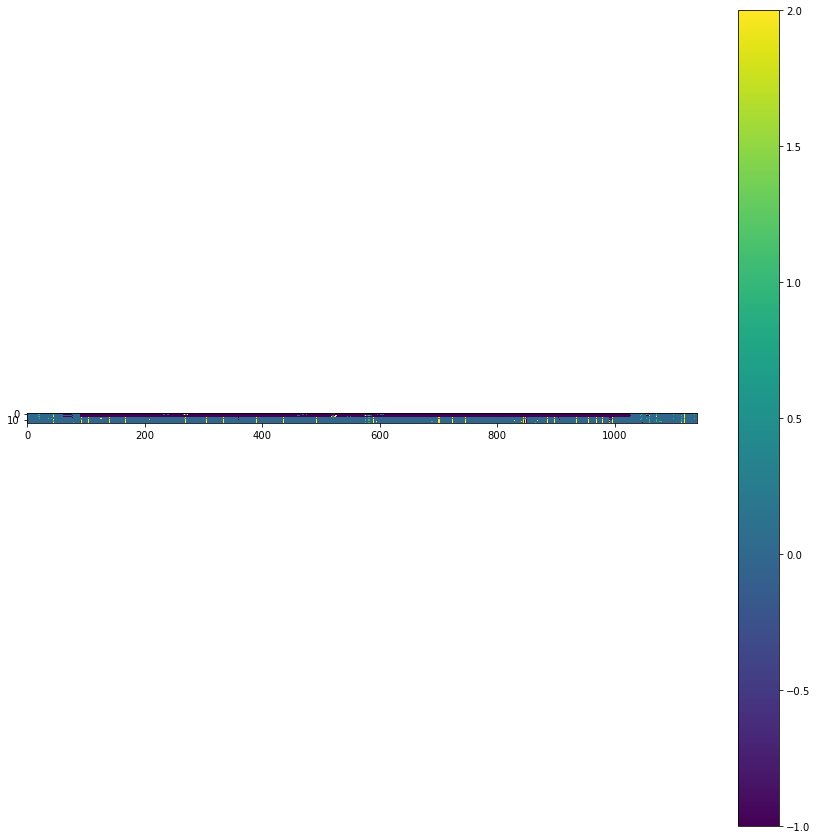

In [697]:
print(known.shape)
plt.figure(figsize=(15, 15))
plt.imshow(np.vstack((segment[[individual_to_indices[x] for x in doubledel_inds], :],
                      segment[[individual_to_indices[x] for x in singledel_inds], :],
                      segment[[individual_to_indices[x] for x in nodel_inds], :])))
plt.colorbar()
plt.show()

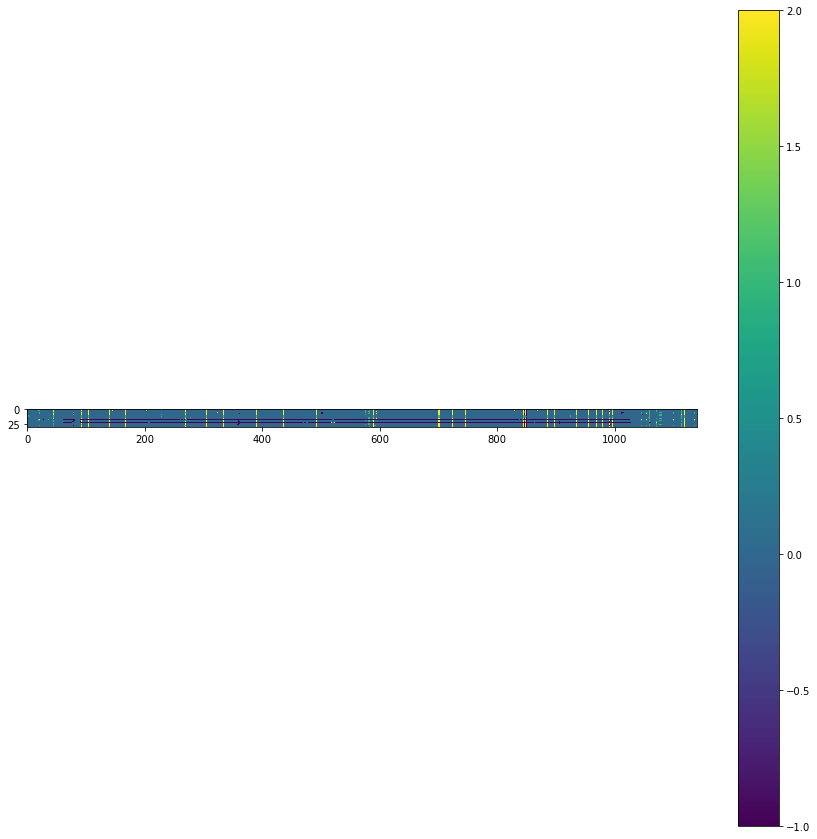

In [698]:
delfams = set([d.family for d in delsofinterest])
other_fams = set(family_to_individuals.keys()) - delfams
other_inds = sum([family_to_individuals[f] for f in other_fams], [])
other_parents = sum([family_to_individuals[f][:2] for f in other_fams], [])
other_children = sum([family_to_individuals[f][2:] for f in other_fams], [])
plt.figure(figsize=(15, 15))
plt.imshow(segment[[individual_to_indices[x] for x in other_inds], :])
plt.colorbar()
plt.show()